# 用朴素贝叶斯模型对Yelp网站的评论文本进行分类

## 第一步：读入数据

把`yelp.csv`读入一个DataFrame中。

In [1]:
# read csv
import pandas as pd

url = "yelp.csv"
yelp = pd.read_csv(url)
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


创建一个新的DataFrame，只包含5颗星和1颗星评分的数据。

In [2]:
# filter data
yelp_binary = yelp[yelp['stars'].isin([1, 5])].copy()
print("筛选后的数据形状:", yelp_binary.shape)
print("\n星级分布:")
print(yelp_binary['stars'].value_counts().sort_index())

筛选后的数据形状: (4086, 10)

星级分布:
stars
1     749
5    3337
Name: count, dtype: int64


## 第二步：生成X和y

使用评论文本作为唯一的分类特征，评分星数作为预测目标，并将数据集划分为训练集和测试集。

In [3]:
# define X and y
from sklearn.model_selection import train_test_split

In [4]:
# split into training and testing sets
yelp_binary = yelp[yelp.stars.isin([1, 5])]

X = yelp_binary.text
y = yelp_binary.stars

# 将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## 第三步：转换数据

使用CountVectorizer将X_train和X_test转换为document-term矩阵。

In [5]:
# import and instantiate the vectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
# fit and transform X_train, but only transform X_test
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

## 第四步：训练、预测、评价

使用朴素贝叶斯预测测试集中评论的星级评分，并计算预测精度。

In [7]:
# import/instantiate/fit
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt

In [8]:
# make class predictions
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [9]:
# calculate accuracy
y_pred_class = nb.predict(X_test_dtm)

计算AUC。注意：y_test中的取值是1和5，需要先把它转换为取值为0和1的二值数组y_test_binary。

In [10]:
# create y_test_binary from y_test, which contains ones and zeros instead
y_test_binary = (y_test == 5).astype(int)

In [11]:
# predict class probabilities
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

In [12]:
# calculate the AUC using y_test_binary and y_pred_prob
auc = metrics.roc_auc_score(y_test_binary, y_pred_prob)
print(f"AUC: {auc:.4f}")

AUC: 0.9392


绘制ROC曲线。

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

D:\AI_ML\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\AI_ML\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\AI_ML\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\AI_ML\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\AI_ML\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\AI_ML\Lib\site-packages\IPython\

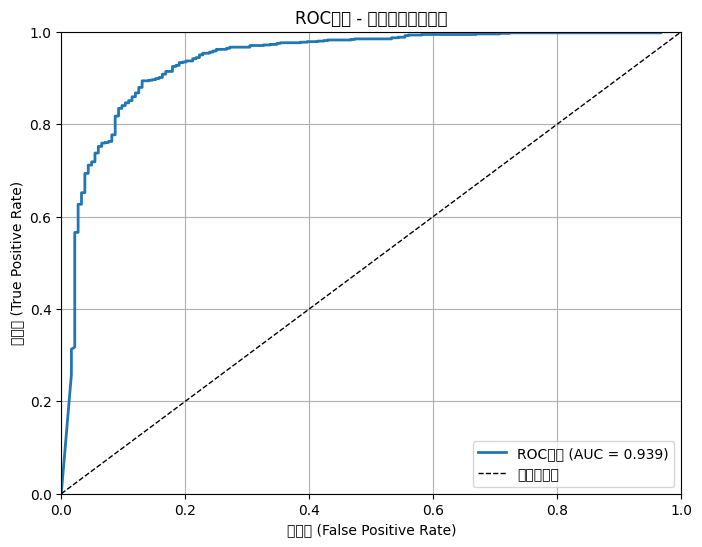

In [14]:
# plot ROC curve using y_test_binary and y_pred_prob

fpr, tpr, thresholds = metrics.roc_curve(y_test_binary, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC曲线 (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='随机分类器')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('假正率 (False Positive Rate)')
plt.ylabel('真正率 (True Positive Rate)')
plt.title('ROC曲线 - 朴素贝叶斯分类器')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

显示混淆矩阵，并计算敏感度和特异性，评论结果。

In [15]:
# print the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_class)
print("混淆矩阵:")
print(confusion_matrix)


混淆矩阵:
[[126  58]
 [ 25 813]]


In [16]:
# calculate sensitivity
tn, fp, fn, tp = confusion_matrix.ravel()
sensitivity = tp / (tp + fn)  # 召回率/真正率
specificity = tn / (tn + fp)  # 真负率


In [17]:
# calculate specificity
print(f"\n敏感度 (Sensitivity/Recall): {sensitivity:.4f}")
print(f"特异性 (Specificity): {specificity:.4f}")


敏感度 (Sensitivity/Recall): 0.9702
特异性 (Specificity): 0.6848


对模型的敏感度和特异性做出评论：

## 第五步：错误分析

查看测试集中一些被预测错误的评论文本，即false positives和false negatives。试着回答为什么这些评论会被预测错。

In [18]:
# first 10 false positives (meaning they were incorrectly classified as 5-star reviews)
import numpy as np

# 将预测结果转换为数组
y_pred_array = np.array(y_pred_class)
y_test_array = np.array(y_test)

In [19]:
# first 10 false negatives (meaning they were incorrectly classified as 1-star reviews)
false_positives = X_test[(y_test_array == 1) & (y_pred_array == 5)]
print("前10个假正例 (False Positives):")
for i, review in enumerate(false_positives.head(10)):
    print(f"{i+1}. {review[:200]}...")

print("\n" + "="*80 + "\n")

前10个假正例 (False Positives):
1. This has to be the worst restaurant in terms of hygiene. Two of my friends had food -poisoning after having dinner here. The food is just unhealthy with tons of oil floating on the top of curries, and...
2. If you like the stuck up Scottsdale vibe this is a good place for you. The food isn't impressive. Nice outdoor seating....
3. I'm sorry to be what seems to be the lone one star review.  Either I got there on the worst day in their history, or everyone drank the Koolaid, or I just have different expectations and taste buds.
I...
4. Went last night to Whore Foods to get basics to make pizza with, most clutch to the process was a three pack of yeast. Low and behold, the dirty hippie kids they have working there again didn't put so...
5. I found Lisa G's while driving through phoenix with a friend. The exterior looked promising and we prepared ourselves for a treat. We were in for a a shock! We ordered the antipasto plate and while th...
6. Don't know where

## 第六步：多分类预测

使用所有的评论做预测，而不仅仅是评分1星和5星的评论。

In [20]:
# define X and y using the original DataFrame
X_multi = yelp.text
y_multi = yelp.stars

In [21]:
# split into training and testing sets
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, random_state=1)

In [22]:
# create document-term matrices
vect_multi = CountVectorizer()
X_train_dtm_multi = vect_multi.fit_transform(X_train_multi)
X_test_dtm_multi = vect_multi.transform(X_test_multi)

In [23]:
# fit a Naive Bayes model
nb_multi = MultinomialNB()
nb_multi.fit(X_train_dtm_multi, y_train_multi)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [24]:
# make class predictions
y_pred_multi = nb_multi.predict(X_test_dtm_multi)


In [25]:
# calculate the testing accuary
accuracy_multi = metrics.accuracy_score(y_test_multi, y_pred_multi)
print(f"多分类测试准确率: {accuracy_multi:.4f}")

多分类测试准确率: 0.4712


In [26]:
# print the confusion matrix
confusion_matrix_multi = metrics.confusion_matrix(y_test_multi, y_pred_multi)
print("\n多分类混淆矩阵:")
print(confusion_matrix_multi)

# 分类报告
print("\n分类报告:")
print(metrics.classification_report(y_test_multi, y_pred_multi))


多分类混淆矩阵:
[[ 55  14  24  65  27]
 [ 28  16  41 122  27]
 [  5   7  35 281  37]
 [  7   0  16 629 232]
 [  6   4   6 373 443]]

分类报告:
              precision    recall  f1-score   support

           1       0.54      0.30      0.38       185
           2       0.39      0.07      0.12       234
           3       0.29      0.10      0.14       365
           4       0.43      0.71      0.53       884
           5       0.58      0.53      0.55       832

    accuracy                           0.47      2500
   macro avg       0.45      0.34      0.35      2500
weighted avg       0.46      0.47      0.43      2500



有何评论：